In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [168]:
#load data
X = pd.read_csv('data/data_preprocessed.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('data/test_data_preprocessed.csv').drop('Unnamed: 0', axis=1)
y = pd.read_csv('data/outcome.csv')['HeartDisease']
y_test = pd.read_csv('data/outcome_test.csv')['HeartDisease']

VALIDATION_SPLIT = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [169]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [170]:
#training loop
training_loss = []
NUMBER_EPOCHS = 100
for epoch in range(NUMBER_EPOCHS):
    model.train()
    train_loss = 0
    for patients, labels in train_loader:
        patients, labels = patients.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(patients)
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    #validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for patients, labels in val_loader:
            patients, labels = patients.to(device), labels.to(device)
            outputs = model(patients)
            val_loss += criterion(outputs.view(-1), labels.float()).item()
        avg_val_loss = val_loss / len(val_loader)
    training_loss.append([avg_train_loss, avg_val_loss])
    #print(f"Epoch {epoch+1}/{NUMBER_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

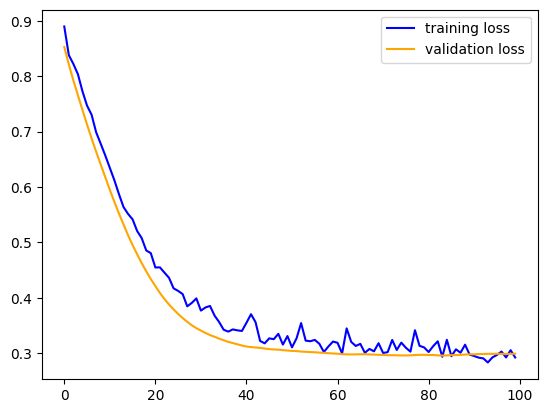

In [171]:
training_loss = np.array(training_loss)
plt.plot(training_loss[:, 0], color='blue')
plt.plot(training_loss[:, 1], color='orange')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [172]:
#test loop
def test_loop(data_loader):
    model.eval()
    epoch_output = []
    all_labels = []
    with torch.no_grad():
        for patients, labels in data_loader:
            patients, labels = patients.to(device), labels.to(device)
            outputs = model(patients).view(-1)
            epoch_output.append(outputs.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(epoch_output).numpy(), torch.cat(all_labels).numpy()

In [173]:
print('----[TRAIN RESULTS]----')
pred, label = test_loop(train_loader)
print('F1 score:', f1_score(label, pred > 0.5))
print('ROC AUC:', roc_auc_score(label, pred))
print('----[VAL RESULTS]----')
pred, label = test_loop(val_loader)
print('F1 score:', f1_score(label, pred > 0.5))
print('ROC AUC:', roc_auc_score(label, pred))
print('----[TEST RESULTS]----')
pred, label = test_loop(test_loader)
print('F1 score:', f1_score(label, pred > 0.5))
print('ROC AUC:', roc_auc_score(label, pred))

----[TRAIN RESULTS]----
F1 score: 0.8861538461538462
ROC AUC: 0.9434431032462206
----[VAL RESULTS]----
F1 score: 0.8859060402684564
ROC AUC: 0.9460711638250556
----[TEST RESULTS]----
F1 score: 0.8648648648648648
ROC AUC: 0.9055282555282556
